# Wavelet Transform #

1. Load images 

2. Convert to gray scale 

2. Wavelet transform 

In [1]:
import numpy as np
import cv2
import pywt
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

Have to look into different wavelet transforms and choose the best one 

In [2]:
# Load frames into a 3D array
def load_frames(frame_paths):
    frames = [cv2.imread(frame) for frame in frame_paths]
    return np.stack(frames, axis=0)

# Apply 3D wavelet transform
def apply_3d_wavelet(frames, wavelet='db1'):
    coeffs = pywt.dwtn(frames, wavelet)
    return coeffs

def select_frames(directory, step=5):
    # Construct the path pattern to match all frames in the directory
    path_pattern = os.path.join(directory, '*.jpg')  # Adjust the extension if needed

    # Get a sorted list of all frame paths
    all_frames = sorted(glob.glob(path_pattern))

    # Select every 'step'th frame, including the first and last frames
    selected_frames = [all_frames[0]] + all_frames[1:-1:step] + [all_frames[-1]]

    return selected_frames

def convert_to_grayscale(frames):
    # Averaging across the color channels
    grayscale_frames = np.mean(frames, axis=-1)
    return grayscale_frames

In [3]:
# Directory containing the frames
frame_directory = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames/MY16/1.1_6_my16_74_Set0_Pos0_Ch5_14012018_150051'

# Get the selected frame paths
frame_paths = select_frames(frame_directory)

frames = load_frames(frame_paths)

# Assuming 'frames' is your original array of video frames
grayscale_frames = convert_to_grayscale(frames)

wavelet_coeffs = apply_3d_wavelet(grayscale_frames)

In [4]:
grayscale_frames.shape

(29, 2048, 2048)

## Visualization ##

### Wavelet Coeffcient Heatmap ###

Allows to look at the distribution of intensities of coeffcient values

The number of coefficient sets extracted from a video using a 3D wavelet transform depends on the wavelet used and the level of decomposition. In a 3D discrete wavelet transform (DWT), each level of decomposition splits the data into different frequency bands. For a single level of decomposition with a basic wavelet (like 'Haar'), you get 8 sets of coefficients for a 3D dataset. These sets represent different combinations of low-pass (L) and high-pass (H) filtering along each of the three dimensions (two spatial dimensions and one temporal dimension).

The eight sets of coefficients for a single-level decomposition are:

1. LLL (Low on all three dimensions)

2. LLH (Low on the first two dimensions, High on the third)

3. LHL (Low on the first and third dimensions, High on the second)

4. LHH (Low on the first dimension, High on the second and third)

5. HLL (High on the first dimension, Low on the second and third)

6. HLH (High on the first and third dimensions, Low on the second)

7. HHL (High on the first two dimensions, Low on the third)

8. HHH (High on all three dimensions)

In [5]:
def plot_all_wavelet_heatmaps(coeffs):
    # Create a figure with 8 subplots (2 rows, 4 columns)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # List of coefficient keys
    coeff_keys = ['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']

    for i, key in enumerate(coeff_keys):
        # Extract the coefficients for the current key
        data = coeffs[key]

        # Select a 2D slice for visualization
        if data.ndim == 3:
            mid_frame = data.shape[0] // 2
            data_2d = data[mid_frame, :, :]
        else:
            data_2d = data  # If the data is already 2D

        # Plot heatmap in the corresponding subplot
        ax = axes[i // 4, i % 4]  # Determine the position of the subplot
        sns.heatmap(data_2d, cmap='viridis', ax=ax)
        ax.set_title(f"Heatmap of {key} coefficients")

    # Adjust layout
    plt.tight_layout()
    plt.show()

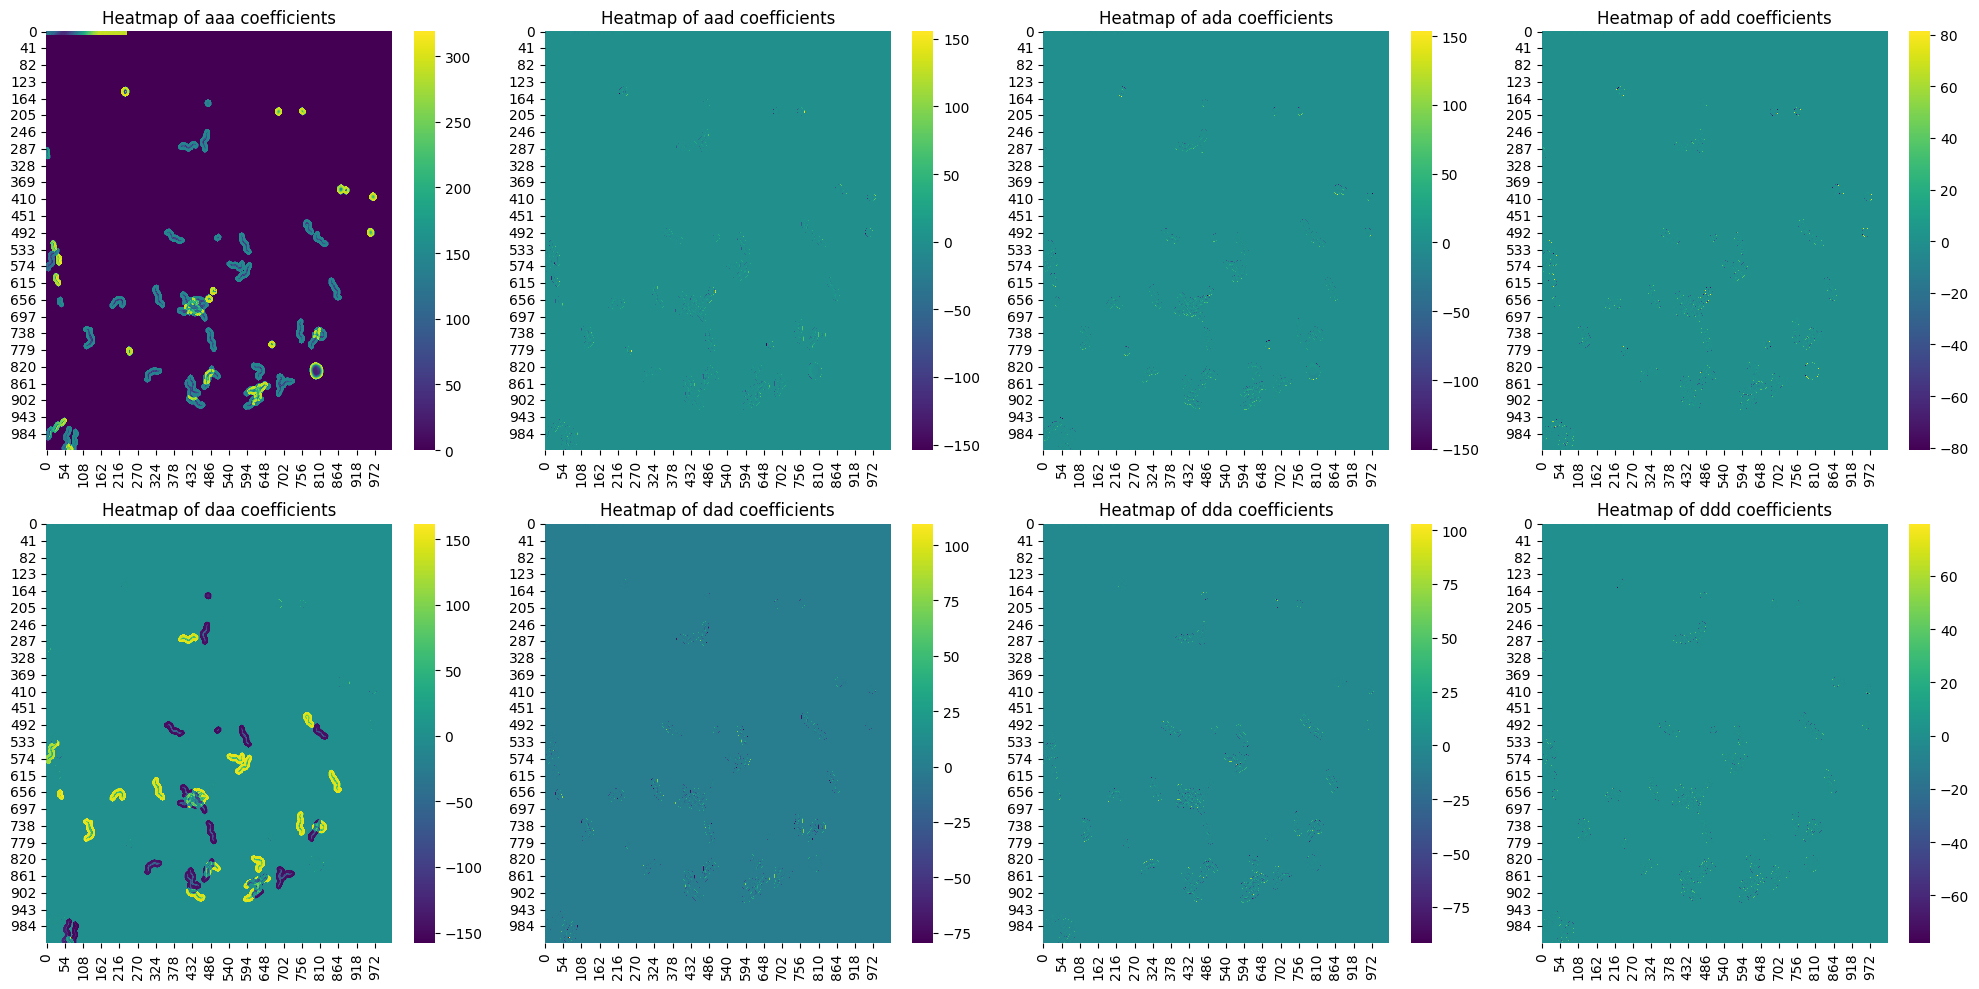

In [6]:
# print name of wavelet coefficients keys 
# print(wavelet_coeffs.keys())

# Assuming coeffs is your dictionary of wavelet coefficients
plot_all_wavelet_heatmaps(wavelet_coeffs)

In [7]:
# Iterate through each key in the wavelet_coeffs dictionary
for key, array in wavelet_coeffs.items():
    # Print the key and the shape of its corresponding array
    print(f"Shape of '{key}' coefficients: {array.shape}")

Shape of 'aaa' coefficients: (15, 1024, 1024)
Shape of 'aad' coefficients: (15, 1024, 1024)
Shape of 'ada' coefficients: (15, 1024, 1024)
Shape of 'add' coefficients: (15, 1024, 1024)
Shape of 'daa' coefficients: (15, 1024, 1024)
Shape of 'dad' coefficients: (15, 1024, 1024)
Shape of 'dda' coefficients: (15, 1024, 1024)
Shape of 'ddd' coefficients: (15, 1024, 1024)


### Temporal Evolution Plots ###

Not sure if this makes sense. Might come useful after. The spatial_location in plot_temporal_evolution allows you to selct a specifc part of the image spatialy [x,y]. This might come sueful after.  

In [8]:
def plot_temporal_evolution(coeffs, coeff_set, spatial_location):
    # Extract the specific set of coefficients
    coeff_data = coeffs[coeff_set]

    # Check if the data is 3D
    if coeff_data.ndim != 3:
        raise ValueError("Coefficient data is not 3D. Check the data structure.")

    # Time series for the specific spatial location
    time_series = coeff_data[:, spatial_location[0], spatial_location[1]]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(time_series)
    plt.title(f"Temporal Evolution of Coefficients at {spatial_location} in {coeff_set}")
    plt.xlabel('Frame Number')
    plt.ylabel('Coefficient Value')
    plt.show()

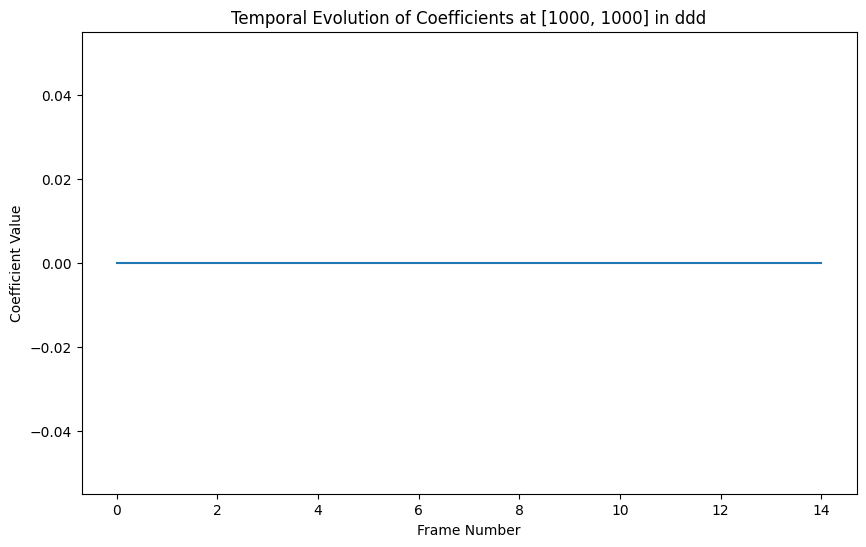

In [10]:
plot_temporal_evolution(wavelet_coeffs, 'ddd',[1000, 1000])

In [10]:
def plot_3d_surface(coeffs, coeff_set, frame_index):
    # Extract the coefficients for a specific frame
    frame_coeffs = coeffs[coeff_set][frame_index]

    # Create a meshgrid for the spatial dimensions
    X, Y = np.meshgrid(range(frame_coeffs.shape[1]), range(frame_coeffs.shape[0]))

    # 3D Surface Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, frame_coeffs, cmap='viridis', edgecolor='none')

    # Labels and Title
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Coefficient Intensity')
    ax.set_title(f"3D Surface Plot of '{coeff_set}' Coefficients - Frame {frame_index}")

    # Show the plot
    plt.show()

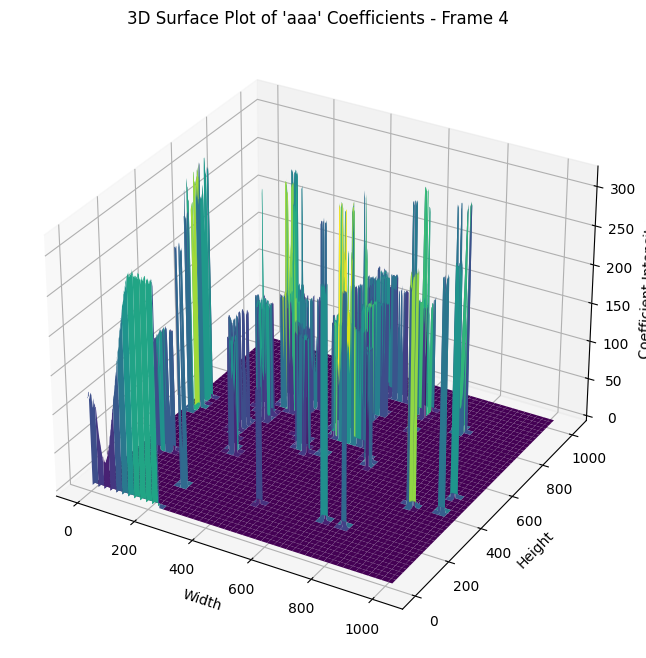

In [11]:
plot_3d_surface(wavelet_coeffs, 'aaa', 4)  # Visualize the first frame's 'aaa' coefficients

In [12]:
def interactive_3d_surface(coeffs, coeff_set):
    def plot(frame_index=0):
        frame_coeffs = coeffs[coeff_set][frame_index]
        X, Y = np.meshgrid(range(frame_coeffs.shape[1]), range(frame_coeffs.shape[0]))

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.clear()
        surf = ax.plot_surface(X, Y, frame_coeffs, cmap='viridis', edgecolor='none')
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')
        ax.set_zlabel('Coefficient Intensity')
        ax.set_title(f"3D Surface Plot of '{coeff_set}' Coefficients - Frame {frame_index}")

    # Create a slider to select the frame number
    frame_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(coeffs[coeff_set]) - 1,
        step=1,
        description='Frame Number:',
        continuous_update=False
    )

    # Create an interactive widget
    widgets.interact(plot, frame_index=frame_slider)

In [13]:
# Example usage
interactive_3d_surface(wavelet_coeffs, 'aaa')

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame Number:', max=14), Output…

### Histogram coeffcients ###

 Histograms of Coefficients
Description: Use histograms to show the distribution of wavelet coefficients.
Implementation: matplotlib or seaborn can be used for histogram creation.
Advantages: Good for statistical analysis of the coefficients, understanding the spread and common values.

In [14]:
def plot_histograms_all_coeffs(coeffs_dict):
    # Determine the grid size
    num_coeffs = len(coeffs_dict)
    cols = 2  # for example, you can choose a different number
    rows = num_coeffs // cols + num_coeffs % cols

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.ravel()  # Flatten the axes array for easy indexing

    for i, (coeff_name, coeff_array) in enumerate(coeffs_dict.items()):
        # Flatten the coefficients to create a 1D array
        coeffs_flattened = coeff_array.flatten()

        # Plot the histogram on the ith subplot
        axes[i].hist(coeffs_flattened, bins=50, color='blue', edgecolor='black')
        axes[i].set_title(f'Histogram of {coeff_name} Coefficients')
        axes[i].set_xlabel('Coefficient Value')
        axes[i].set_ylabel('Frequency')

    # Hide any unused subplots
    for j in range(i+1, rows * cols):
        axes[j].axis('off')

    # Adjust layout for readability
    plt.tight_layout()
    plt.show()


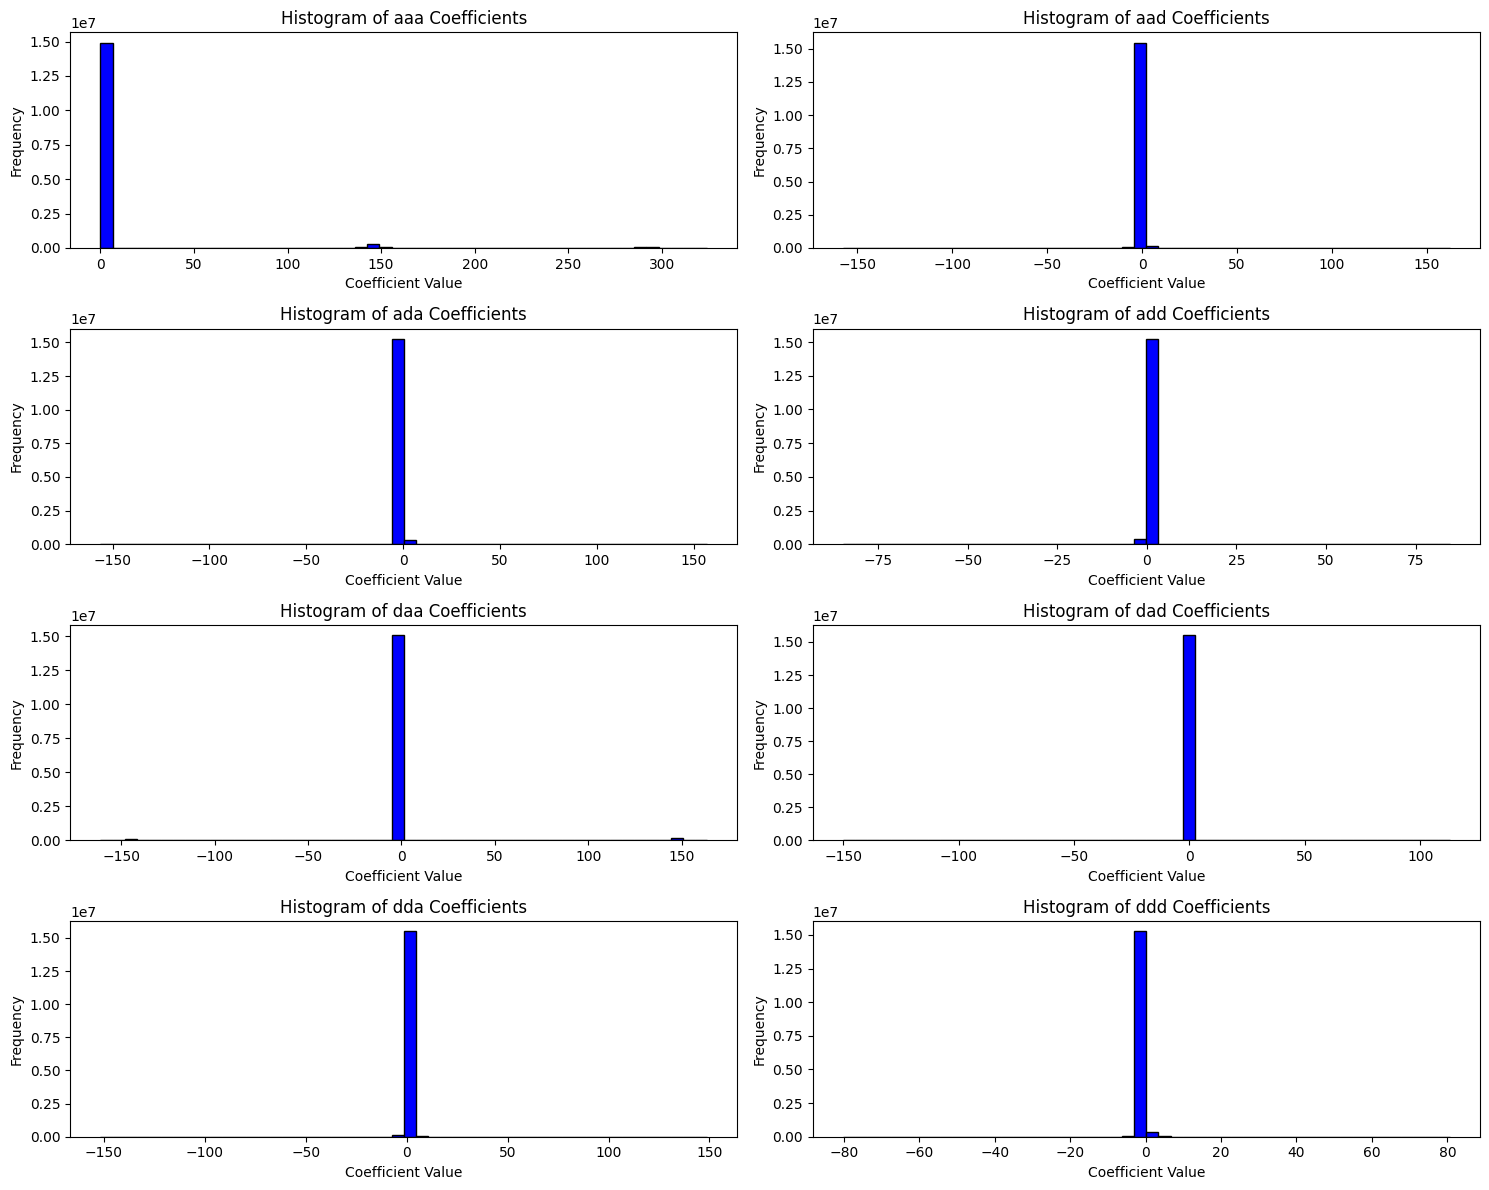

In [15]:
plot_histograms_all_coeffs(wavelet_coeffs)

### Animation of Wavelet Transformed Frames ###

Description: Create an animation showing the transformation of frames over time.
Implementation: Use matplotlib.animation or OpenCV for creating animations.
Advantages: Offers a dynamic and intuitive understanding of changes throughout the video.

In [16]:
from matplotlib.animation import FuncAnimation


def animate_wavelet_transformed_frames(coeffs, coeff_set):
    # Extract the set of coefficients
    frames = coeffs[coeff_set]

    # Set up the figure
    fig, ax = plt.subplots()
    ax.set_title(f"Animation of '{coeff_set}' Coefficients Over Time")

    # Initialize a frame for the animation
    frame = ax.imshow(frames[0], cmap='gray', interpolation='none')
    ax.axis('off')

    # Update function for the animation
    def update(i):
        frame.set_data(frames[i])
        return frame,

    # Create the animation
    anim = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=True)

    return anim

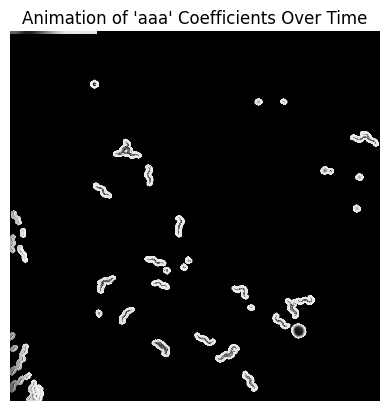

In [17]:
# Assuming 'wavelet_coeffs' is your dictionary of wavelet coefficients
anim = animate_wavelet_transformed_frames(wavelet_coeffs, 'aaa')

from IPython.display import HTML
HTML(anim.to_html5_video())


### Interactive Visualization with Jupyter Widgets ###

Description: Create interactive widgets in Jupyter Notebook for real-time manipulation and visualization of wavelet coefficients.
Implementation: Utilize ipywidgets for slider controls, dropdown menus, etc., to interactively explore different decomposition levels or frames.
Advantages: Provides an interactive environment for exploration and analysis.

In [18]:
def interactive_wavelet_visualization(coeffs_dict):
    # Create a dropdown to select the coefficient set
    coeff_set_dropdown = widgets.Dropdown(
        options=list(coeffs_dict.keys()),
        value=list(coeffs_dict.keys())[0],
        description='Coeff Set:',
    )

    # Create a slider for selecting the frame index
    frame_slider = widgets.IntSlider(
        min=0,
        max=coeffs_dict[list(coeffs_dict.keys())[0]].shape[0] - 1,
        step=1,
        value=0,
        description='Frame:',
    )

    # Function to update the plot
    def update_plot(coeff_set, frame_index):
        plt.figure(figsize=(6, 6))
        plt.imshow(coeffs_dict[coeff_set][frame_index], cmap='gray')
        plt.title(f"{coeff_set} Coefficients - Frame {frame_index}")
        plt.axis('off')
        plt.show()

    # Create interactive widgets
    widgets.interactive(update_plot, coeff_set=coeff_set_dropdown, frame_index=frame_slider)

In [19]:
# Assuming 'wavelet_coeffs' is your dictionary of wavelet coefficients
interactive_wavelet_visualization(wavelet_coeffs)